# Self-Driving Car Engineer Nanodegree

## Advanced Lane Detection 

## Project: Build an advanced lane finding algorithm


# 1. Camera Caliberation

In [11]:
import numpy as np 

# for camera caliberation
import cv2

# for opening files
import os, sys

# for copying image and save them to disk 
import matplotlib.image as mpimg

# randint 
import random

# Plotting images 
import matplotlib.pyplot as plt 

### Define Camera Calibrator class
This project has a object oriented approach towards solving the goal of find lanes in driving videos. CameraCaliberator is the first class which is defined below which inputs the source of images used for caliberation and contains details of the caliberated camera e.g. distortion matrix, radial vector etc

In [12]:
# Camera Caliberator class 
class CameraCaliberator:
    ''' Constructor
    # Input args:
    ## test_images_folder - input folder where all the images required for camera calibration are present
    ## output_folder - where the undistorted images will be output
    ## number_of_corners - corners in the checkboard which need to be used for calibration
    '''
    def __init__(self, test_images_folder, number_of_corners=(8,6)):
        # root_folder containing path to input images folder 
        self.root_folder = test_images_folder
        
        # nx - number of corners in x dimension
        self.nx = number_of_corners[0]
        
        # ny - number of corners in y dimension
        self.ny = number_of_corners[1]
        
        # member variable to store 2-D image points 
        self.image_points = []
        
        # member variable to store 3-D real world object points
        self.object_points = []
        
        # image_shape - shape of the input images
        self.image_shape = None
        
        # member variable to store CameraMatrix 
        self.CameraMatrix = []
        
        # member variable to store DistortionMatrix
        self.DistortionMatrix = []

    ''' computeObjectPoints
    1. This method uses nx and ny to compute default set of real-world object points
    2. Returns object_points
    '''
    def computeObjectPoints(self):
        # Compute default set of object points 
        object_points = np.zeros((self.ny*self.nx, 3), np.float32)

        # reshape object points to x,y coordinates 
        object_points[:,:2] = np.mgrid[0:self.nx, 0:self.ny].T.reshape(-1, 2)
        
        return object_points 
    ''' findChessboardCorners
    # Input args
    # object_points - used in finding chessboard corners of distorted images 
    1 For each image in input folder
    1.1 Applies opencv algorithm "findChessboardCorners" to find the chessboard corners of the gray scale image using (nx, ny)
    1.2 Draws the corners on the gray image and prints a sample image 
    2. Stashes away object points and image points in object member variables
    '''
    def findChessboardCorners(self, object_points):
        # Loop through all images in the root_folders
        idx = 0
        
        # get all the images from root_folder 
        file_list = os.listdir(self.root_folder)
        
        # get the total number of images in the folder 
        self.number_of_images = len(file_list)
        
        # generate a random image index which is used for visualizing the chessboard corners 
        random_image_idx = random.randint(0, len(file_list)-1)
        
        for file in file_list:
            # read image
            image = cv2.imread(self.root_folder+"/"+ file)

            # convert image to grayscale 
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            if self.image_shape is None:
                self.image_shape = gray.shape[::-1]

            # use gray scale image to find chess board corners 
            ret, corners = cv2.findChessboardCorners(gray, (self.nx,self.ny), None)

            if corners is not None and corners.shape[0] == object_points.shape[0]:
                # generate corners identified image
                img_corners = np.copy(image)
                img_corners = cv2.drawChessboardCorners(img_corners, (self.nx,self.ny), corners, ret)

                if idx == random_image_idx:
                    fig=plt.figure();
                    plt.imshow(img_corners)
                    plt.title("Chessboard corners drawn for " + file)
                    plt.show()
                
                self.image_points.append(corners)
                self.object_points.append(object_points)
            idx += 1
    ''' caliberate
    1. Uses object and image points to caliberate camera using opencv algorithm "caliberateCamera"
    1.1 Stashes away camera matrix, distortion matrix, radial vectors and tangential vectors output by caliberateCamera method
    '''
    def caliberate(self):
        # compute object points 
        object_points = self.computeObjectPoints();
    
        # find chessboard corners in each image input 
        self.findChessboardCorners(object_points);
        
        # Calibrate camera using object points and image points
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(self.object_points, self.image_points, self.image_shape, None, None)
        self.CameraMatrix = mtx
        self.DistortionMatrix = dist
        self.RadialVectors = rvecs
        self.TangentialVectors = tvecs
    
    ''' undistort
    # Input args:
    # image - input image which needs to be distorted 
    
    1. Using camera matrix, distortion matrix apply opencv algorithm to undistort given input image 
    2. returns the undistorted image 
    '''
    def undistort(self, image):
        undistorted = np.copy(image)
        if self.CameraMatrix is not None:
            # convert image to grayscale 
            undistorted  = cv2.undistort(image, self.CameraMatrix, self.DistortionMatrix, None, self.CameraMatrix)
        return undistorted


## Calibrate Camera 

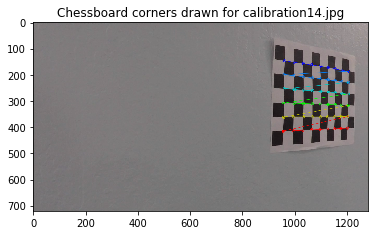

In [13]:
# Invoke Camera Caliberator and caliberate using input images 
cc = CameraCaliberator("camera_cal", (9,6))

# Caliberate method will randomly output the chessboard corners 
# visualization for any one of the images used in calibration
cc.caliberate();


## Undistort sample images 
CameraCaliberator class's undistort image is used to undistort any input image. The code below, uses one of the images in "camera_cal" folder and undistorts them 

In [14]:
import cv2
sample_image_for_undistortion = "camera_cal\\calibration1.jpg"
image = cv2.imread(sample_image_for_undistortion)
undistorted_image = cc.undistort(image)

### Example of distortion corrected image 


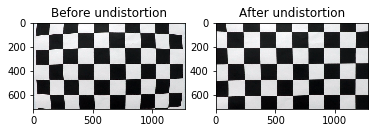

In [15]:
# Plot the before and after undistortion images 

fig, axes = plt.subplots(1, 2)
ax = plt.subplot(1, 2, 1)
ax.set_title("Before undistortion")
ax.imshow(image)

ax = plt.subplot(1, 2, 2)
ax.imshow(undistorted_image)
ax.set_title("After undistortion")

plt.show()


### (Optional) Save the Camera Calibration Parameters 

In [16]:
import pickle 

'''Optional - Save Pickle File containing camera calibration parameters'''
# Cache away the camera caliberation data 
data = {'CameraCalibrator': cc};
pickle_file_name = "camera_calibration.p";
pickle.dump(data, open(pickle_file_name, "wb"))

----

## 2. Pipeline (test images)


### (Optional) Load the Camera Calibration Parameters

In [17]:

pickle_file_name = "camera_calibration.p"
data = pickle.load(open(pickle_file_name, "rb"));
cc = data["CameraCalibrator"]

# Lane Detection Pipeline

In [67]:
# Define a Lane class to receive the characteristics of each lane identified
import numpy as np
class Lane():
    def __init__(self, fit, fitx, ploty, isLeft):
        self.isLeft  = isLeft
        self.fit = fit
        self.fitx = fitx 
        self.ploty = ploty
        self.curvature = None
        self.offset = None
        self.offset_direction = None

In [68]:
# Define a LaneStatistics class to store the best known statistics of all lanes detected across frames
import numpy as np
class LaneStatistics():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        
        #x values for detected line pixels
        self.allx = None  
        
        #y values for detected line pixels
        self.ally = None

In [85]:
# Define a LaneDetector class which given a warped_image after pespective transform can identify lane lines 
class LaneDetector():
    # Constructor
    def __init__(self):
        self.image = None
        self.out_file_name = None
    
        # Number of frames 
        self.frame_count = 0
        
        # Number of frames in left_line 
        self.nframes_left_lane_statistics = LaneStatistics()
        
        # Number of frames in right line 
        self.nframes_right_lane_statistics = LaneStatistics()
        
        # last known good left fit line/lanes 
        self.prev_left_fit = []
        
        # last known good right fit line/lanes 
        self.prev_right_fit = []
        
    # Setters for image and output file names 
    def set_image(self, image):
        self.image = image
    
    def set_output_file(self, file_name):
        self.out_file_name = file_name
    
    ''' detect_and_add_lanees - detects lanes using sub / helper functions, draws them on the input image and also
    finds the radius of curvature and lane offset from the center of image 
    # Input Args
    ## warped_image - image obtained after a prespective transform
    ## file_name - file name in which the embedding of lanes on the image need to be written out 
    '''
    def detect_and_add_lanes(self):
        left_lane = None
        right_lane = None 
        mean_curvature = None
        
        warped_image = self.image
        file_name =  self.out_file_name
        
        # Find left and right lane fits 
        left_lane, right_lane = self.find_lane_fits(warped_image, file_name);

        if left_lane.fit is not None and right_lane.fit is not None:
            # Find radius of curvature using ploty 
            left_lane.curvature = self.compute_radius_of_curvature(left_lane) 
            right_lane.curvature = self.compute_radius_of_curvature(left_lane)
            
            # Compute mean curvature 
            mean_curvature = np.mean([left_lane.curvature, right_lane.curvature])/1000.0;

            # Compute lane offset from the center of the x axis 
            left_lane.offset, left_lane.offset_direction = self.compute_lane_offset(left_lane, right_lane, warped_image.shape[1]/2)
            right_lane.offset, right_lane.offset_direction = left_lane.offset, left_lane.offset_direction
            
            
            # Add line statistics 
            self.add_line_statistics(left_lane, isLeftLane=True)
            self.prev_left_fit = left_lane.fit
            
            self.add_line_statistics(right_lane, isLeftLane=False)
            self.prev_right_fit = right_lane.fit

         # Increment frame count while using this image to process video streams
        self.frame_count+=1
        return left_lane, right_lane, mean_curvature

    '''find_lane_fits - functions finds the left and right lane fits along with the y positions along which the lane fit 
    centroids are found. This method uses the sliding window method in the bottom half of the image for finding lanes for the 
    FIRST FRAME ONLY. There after, it tries to pick the lane fits within the identified sliding windows 
    # Input Args
    ## warped_image - image obtained after a perspective transform
    ## file_name - file name in which the embedding of the lanes on the image need to be written out 
    '''
    def find_lane_fits(self, warped_image, file_name):
        use_sliding_windows = False
        if self.frame_count == 0:
            use_sliding_windows = True
        
        left_lane, right_lane = self.find_lanes(warped_image, file_name, use_sliding_windows);
        
        return left_lane, right_lane
   
    ''' find_lanes = core algorithm which finds lanes in an image 
    # Input Args
    # image - input in which lanes need to be detected 
    # out_file_name - file name to be used where image with lanes will be drawn 
    # number_of_sliding_windows - number of windows to use to find the find the lanes 
    # margin - margin / padding to be added to each window for finding lanes 
    # min_qual_pixels - minimum number of pixels required to get a candidate lane 
    # plot_* - switches to enable visualization of histogram / lane fits 
    '''
    def find_lanes(self, image, out_file_name, number_sliding_windows=9, use_sliding_windows=True):
        # Identify all nonzero pixels of the image
        nonzero = image.nonzero()
        nonzero_y = np.array(nonzero[0])
        nonzero_x = np.array(nonzero[1])

        # Set width of windows +/- margin
        margin = 100
        
        out_img = None
        if use_sliding_windows == True:
            # Slide windows over the image from bottom to top to get the line fit
            out_img, left_lane_inds, right_lane_inds = self.slide_windows(image, number_sliding_windows, nonzero_x, nonzero_y);
        else:
            # Use previous fits to detect good lane indices
            prev_left_fit = self.prev_left_fit
            prev_right_fit = self.prev_right_fit
            left_lane_inds = ((nonzero_x > (prev_left_fit[0]*(nonzero_y**2) + prev_left_fit[1]*nonzero_y + prev_left_fit[2] - margin)) & (nonzero_x < (prev_left_fit[0]*(nonzero_y**2) + prev_left_fit[1]*nonzero_y + prev_left_fit[2] + margin))) 
            right_lane_inds = ((nonzero_x > (prev_right_fit[0]*(nonzero_y**2) + prev_right_fit[1]*nonzero_y + prev_right_fit[2] - margin)) & (nonzero_x < (prev_right_fit[0]*(nonzero_y**2) + prev_right_fit[1]*nonzero_y + prev_right_fit[2] + margin)))  

        # Fit a polynomial line using the indices found
        try:
            # once the candidates of line indices are obtained, fit a polynomial
            left_fit = self.fit_lane_line(left_lane_inds, nonzero_x, nonzero_y)
            right_fit = self.fit_lane_line(right_lane_inds, nonzero_x, nonzero_y)
        except ValueError:
            # If line fit fails, resolve to the previous known best fit 
            left_fit = self.nframes_left_line.best_fit
            right_fit = self.nframes_right_line.best_fit

            
        # Compute the visualization elements of the lane 
        ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        left_lane = Lane(left_fit, left_fitx, ploty, isLeft=True);
        right_lane = Lane(right_fit, right_fitx, ploty, isLeft=False);
        return left_lane, right_lane
    ''' slide_windows - method slides windows from left to right in the lower half of the image to identify
    pixel indices where lanes can be found
    '''
    def slide_windows(self, image, number_sliding_windows, nonzero_x, nonzero_y):
        
        nwindows = number_sliding_windows
        window_height = np.int(image.shape[0]/nwindows)

        leftx_current, rightx_current = self.get_x_base_for_lanes(image)

        margin=100
        min_qual_pixels=50
        
        # Create an output image to draw on and  visualize the result
        sliding_window_image = np.dstack((image, image, image))*255
        left_lane_inds = []
        right_lane_inds = []
        for window in range(nwindows):
            # identify window boundaries x, y , right and left 
            l_low, l_high, r_low, r_high, y_low, y_high = self.compute_margins(image.shape[0], window_height, window, margin, leftx_current, rightx_current);
            
            # Draw the windows on the visualization image
            sliding_window_image = cv2.rectangle(sliding_window_image,(l_low,y_low),(l_high,y_high),(0,255,0), 6) 
            sliding_window_image = cv2.rectangle(sliding_window_image,(r_low,y_low),(r_high,y_high),(0,255,0), 6) 

            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzero_y >= y_low) & (nonzero_y < y_high) & (nonzero_x >= l_low) & (nonzero_x < l_high)).nonzero()[0]
            good_right_inds = ((nonzero_y >= y_low) & (nonzero_y < y_high) & (nonzero_x >= r_low) & (nonzero_x < r_high)).nonzero()[0]

            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > min_qual_pixels:
                leftx_current = np.int(np.mean(nonzero_x[good_left_inds]))
            if len(good_right_inds) > min_qual_pixels:        
                rightx_current = np.int(np.mean(nonzero_x[good_right_inds]))

            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        return sliding_window_image, left_lane_inds, right_lane_inds
    ''' get_x_base_for_lanes - method computes the set of pixels of interest in x dimension to locate left lane and right lane respectively
    '''
    def get_x_base_for_lanes(self, image):
         # Compute histogram of image in the lower half of the image for values in the x axis 
        histogram = np.sum(image[image.shape[0]//2:,:], axis=0)
        
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        
        return leftx_base, rightx_base
   
    ''' compute_margins - method helps in computing the padded window dimensions given a leftx and right x position along 
    with a margin width 
    '''
    def compute_margins(self, total_height, window_height, window_id, margin, leftx_current, rightx_current):
        y_low = total_height - (window_id + 1) * window_height
        y_high = total_height - window_id * window_height
        xleft_low = leftx_current - margin
        xleft_high = leftx_current + margin
        xright_low = rightx_current - margin
        xright_high = rightx_current + margin
        return xleft_low, xleft_high, xright_low, xright_high, y_low, y_high
    '''fit_lane_line - method uses the left and right lane indices along with nonzero_x and y to get a polynomial line fit 
    '''
    def fit_lane_line(self, lane_inds, nonzero_x, nonzero_y):
        # Extract left and right line pixel positions
        x = nonzero_x[lane_inds]
        y = nonzero_y[lane_inds] 
        
        # Fit a second order polynomial to each
        fit = np.polyfit(y, x, 2)
        return fit
    
    ''' compute_radius_of_curvature - method helps compute the radius of curvature of a line given ploty, left fit and right fit
    '''
    def compute_radius_of_curvature(self, lane):
        #Define y-value where we want radius of curvature
        # I'll choose the maximum y-value, corresponding to the bottom of the image
        y_eval = np.max(lane.ploty)

        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        fit_cr = np.polyfit(lane.ploty*ym_per_pix, lane.fitx*xm_per_pix, 2)
        
        # Calculate the new radii of curvature
        curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
        
        return curverad

    ''' compute_lane_offset - function finds the offset of left and right lanes given the midpoint of the image
    and its direction of offset(left or right)
    # Input Args 
    # left_fitx - left fit lane's x values
    # right_fitx - right fit lanes' x values 
    # midpoint - mid point of the image 
    '''
    def compute_lane_offset(self, left_lane, right_lane, midpoint):
        # find the lane width
        left_fitx = left_lane.fitx
        right_fitx = right_lane.fitx
        
        lane_width = np.absolute(left_fitx[0] - right_fitx[0])
        
        # find the lane center wrt width of the lane 
        lane_center = left_fitx[0] + (lane_width/2)
        
        # find the offset of lanes from the mid point of the image 
        offset = lane_center - midpoint
        
        # Do a conversion from pixels to meters 
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        offset_in_meters = offset*xm_per_pix
        
        # If offset is < 0 then the lane center is skewed to the right 
        # otherwise the lane center is to the left of the midpoint of the image
        offset_direction = "left";
        if offset < 0:
            offset_direction = "right"
        
        # return offset and offset direction
        return offset_in_meters, offset_direction
    ''' add_line_statistics - analyzes the current fit and previous fit along with other statistical information
    like offset, offset direction and updates them for each frame
    # Input Args
    # line             - line object to which the statistics needs to be added 
    # fit              - line fit found for a given image (left / right fit)
    # prev_fit         - previously known fit 
    # fitx             - x values involved in the fit 
    # ploty            - y values used for plotting the fit 
    # curvature        - radius of curvature observe for the line fit 
    # offset           - line offset from the middle of the image 
    # offset_direction - offset direction
    '''
    def add_line_statistics(self, lane, isLeftLane):
        if isLeftLane==True:
            lane_statistics = self.nframes_left_lane_statistics
            prev_fit = self.prev_left_fit
        else:
            lane_statistics = self.nframes_right_lane_statistics
            prev_fit = self.prev_right_fit
        
        
        # was the line detected in the last iteration?
        lane_statistics.detected = True
        
        # x values of the last n fits of the line
        lane_statistics.recent_xfitted = lane.fitx
        
        #average x values of the fitted line over the last n iterations
        if lane_statistics.bestx is not None:
            lane_statistics.bestx = np.mean([np.mean(lane.fitx), lane_statistics.bestx/self.frame_count])     
        else:
            lane_statistics.bestx = np.mean(lane.fitx)
            
            
        #polynomial coefficients averaged over the last n iterations
        if lane_statistics.best_fit is not None:
            lane_statistics.best_fit = [np.mean([lane_statistics.best_fit[0]/self.frame_count, lane.fit[0]]), np.mean([lane_statistics.best_fit[1]/self.frame_count, lane.fit[1]]), np.mean([lane_statistics.best_fit[2]/self.frame_count, lane.fit[2]])]
        else:
            lane_statistics.best_fit = lane.fit
            
            
        #polynomial coefficients for the most recent fit
        lane_statistics.current_fit = lane.fit
        
        #radius of curvature of the line in some units
        lane_statistics.radius_of_curvature = lane.curvature
        
        #distance in meters of vehicle center from the line
        lane_statistics.offset = lane.offset
        lane_statistics.offset_direction = lane.offset_direction
        
        #difference in fit coefficients between last and new fits
        if prev_fit is not None and len(prev_fit) == 3:
            lane_statistics.diffs = prev_fit - lane.fit
            
            
        #x values for detected line pixels
        lane_statistics.allx = lane.fitx  
        #y values for detected line pixels
        lane_statistics.ally = lane.ploty
   
    
   
    

In [86]:
# cv2
import cv2

# os, sys for iterating over files in folders
import os, sys

# 
import numpy as np

# for copying image and save them to disk 
import matplotlib.image as mpimg

import matplotlib.pyplot as plt


In [87]:
''' Lane Detection Pipeline 
This class defines the pipeline required for detecting lanes in an image 
'''
class LaneDetectionPipeline:
    ''' Constructor 
    # Input args
    ## CameraCaliberation - cameraCaliberator object which has the required distortion matrix to undistort images 
    ## root_folder        - where input images are present
    ## output_folder      - where output images with lane detected and painted are output
    '''
    def __init__(self, cameraCalibration, root_folder, output_folder):
        # root folder 
        self.root_folder = root_folder
        
        # output folder 
        self.output_folder = output_folder
        
        # Camera Caliberation object 
        self.cameraCalibration = cameraCalibration
        
        # Lane Detector object
        self.laneDetector = LaneDetector();

    ''' Execute method 
    1. Reads all images from the root / input folder 
    2. Invokes process_image method for each image in the folder 
    '''
    def execute(self):
        print ("Starting pipeline for lane detection... ")
        # Loop through all images in the root_folders
        file_list = os.listdir(self.root_folder)
        for file in file_list:
            print("Image: " + file)
            # read image
            image = cv2.imread(self.root_folder+"/"+ file)
            
            output_image  = self.process_image(image, file);
            
            if output_image is None:
                fig = plt.figure();
                plt.imshow(output_image)
                plt.show()
            

    ''' imsave - Helper method to save intermediate results of pipeline 
    '''
    def imsave(self, image, file_name, suffix_name, isgray=False):
        if isgray == True:
            mpimg.imsave(self.output_folder + "/" + file_parts[0] +"_" + suffix_name + ".png" , image, cmap="gray");
        else:
            mpimg.imsave(self.output_folder + "/" + file_parts[0] +"_" + suffix_name + ".png" , image);

        
    ''' Process Image method defines the key pipeline required to detect lanes in an image
    # Input args:
    ## image - actual image 
    ## file - file name (prefix which can be used to output intermediate images after each stage of the pipeline
    '''
    def process_image(self, image, file="sample"):
        # extract the file name 
        file_parts  = file.split(".")
        
        ''' Lane Detection Pipeline 
        1. Undistort Image 
        2. Apply color threshold 
        3. Apply gradient threshold 
        4. Compute perspective matrix 
        5. Detect And Add Lanes 
        '''
        ## 1. Undistort Image 
        # Use camera caliberator to undistort image
        image = self.cameraCalibration.undistort(image);
        #self.imsave(image, file_parts[0], "Undistorted")
        
        color_binary = self.apply_color_threshold(image)
        #self.imsave(image, file_parts[0], "ColorBinary", True)
        
        mag_sobel_binary, direction_binary = self.apply_gradient_threshold(color_binary)

        # Combine the two binary thresholds
        combined_binary = np.zeros_like(color_binary)
        combined_binary[(mag_sobel_binary == 1) | (direction_binary == 1)] = 1
        # self.imsave(combined_binary, file_parts[0], "Out", True)
        
        # Compute perspective matrices
        M, Minv = self.compute_perspective_matrix(combined_binary);

        # Compute warped image
        warped_image = self.apply_perspective(M, combined_binary)
        # self.imsave(warped_image, file_parts[0], "Warped", True)
        
        # Detect Lanes
        self.laneDetector.set_image(warped_image)
        self.laneDetector.set_output_file(file_parts[0])
        
        left_lane, right_lane, mean_curvature = self.laneDetector.detect_and_add_lanes();
        
        # Generate output image 
        output_image = self.generate_output(image, warped_image, Minv, left_lane, right_lane, mean_curvature)
        
        # self.imsave(output_image, file_parts[0], "FinalOutput")
       
        return output_image
    
    ''' apply_color_threshold  - function converts an input image to another colorspace (HLS / HSV) 
    and applies the min and max threshold on the values of the appropriate channel 
    # Input Args
    ## image = image to be converted to the new color space
    ## color_space = colorspace to which image needs be to converted to
    ## thresh_channel = Channel index on which thresholding needs to be applied
    ## thresh = tuple consisting of lower and upper threshold limits 
    '''
    def apply_color_threshold(self, image, color_space="HLS", thresh_channel=2, thresh=(70, 255)):
        image_in_colorspace = [];
        if color_space == "HLS":
            image_in_colorspace = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == "HSV":
            image_in_colorspace = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        else:
            image_in_colorspace = np.copy(image)

        thresholding_channel = image_in_colorspace[:, :, thresh_channel]

        # Create a binary mask where the thresholding is applied
        color_binary = np.zeros_like(thresholding_channel)
        color_binary[(thresholding_channel >= thresh[0]) & (thresholding_channel <= thresh[1])] = 1

        # Cache away as object's member variable
        self.image_in_colorspace = thresholding_channel
        
        # return color_binary_mask
        return color_binary

    ''' apply_gradient_threshold - function computes sobel x and sobel y gradient and applies the respective thresholds 
    # Input Args
    ## image = image to be converted to the new color space
    ## abs_thresh = tuple consiting of lower and upper threshold limits for absolute value of sobel gradient
    ## direction_thresh = tuple consiting of lower and upper threshold limits for direction of sobel gradient
    '''
    def apply_gradient_threshold(self, image, abs_thresh=(20, 100), direction_thresh=(0.7, 1.3)):
        # Compute sobel x gradient 
        scaled_sobel_x = self.get_scaled_sobel(image, orient="x")
        
        # Apply thresholds for the magnitude
        mag_sobel_binary = np.zeros_like(scaled_sobel_x)
        mag_sobel_binary[(scaled_sobel_x >= abs_thresh[0]) & (scaled_sobel_x <= abs_thresh[1])] = 1

        # Compute sobel y gradient 
        scaled_sobel_y = self.get_scaled_sobel(image, orient="y")
        
        # Apply thresholds for the direction 
        direction_gradient = np.arctan2(scaled_sobel_y, scaled_sobel_x)
        direction_binary = np.zeros_like(direction_gradient)
        direction_binary[(direction_gradient > direction_thresh[0]) & (direction_gradient <= direction_thresh[1])] = 1
        
        # return the magnitude and direction binary mask 
        return mag_sobel_binary, direction_binary
    ''' compute_perspective_matrix - inputs image and computes the perspective transform 
    # Input Args
    # image - input image to be transformed
    '''
    def compute_perspective_matrix(self, image):
        # Take image shape 
        image_shape = image.shape;
        
        # compute width and height 
        w = image_shape[1];
        h = image_shape[0];
        
        #offset = 200;
        #src = np.float32([[210, h-20], [w/2 - 40, h/2 + 90 ], [w/2 + 40 , h/2 + 90],[1070, h-20]])
        #dst = np.float32([[210+offset, h-20], [210+offset, 0 ], [1070- offset , 0],[1070-offset, h-20]])
        
        # Create a ball park of src and destination points 
        src = np.float32([ [200,720],[600,450],[1150,720],[700,450]])
        dst = np.float32([ [350,720],[350,0],  [1000,720],[1000,0]])
        
        # Use the mapping to create a perspective transform 
        M = cv2.getPerspectiveTransform(src, dst)
        
        # Use the mapping to get inverse perspective transform
        Minv = cv2.getPerspectiveTransform(dst, src)
        
        return M, Minv

    ''' apply_perspective - uses a perspective transform matrix and applies into image 
    # Input Args 
    # image - image to be transformed 
    # M - perspective transform matrix 
    '''
    def apply_perspective(self, M, image):
        img_size = (image.shape[1], image.shape[0])
        warped_image = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
        return warped_image

   
    ''' apply_color_mask - method to apply color mask given a low and high threshold 
    
    '''
    def apply_color_mask(self, image, low_threshold, high_threshold):
        binaries = [];
        h,l,s = cv2.split(image)
        binary = np.zeros_like(h)
        binary[(h >= low_threshold[0]) & (h <= high_threshold[0]) & (l >= low_threshold[1]) & (l <= high_threshold[1]) & (s >= low_threshold[2]) & (s <= high_threshold[2])] = 1
        mpimg.imsave(self.output_folder + "/sample_colormask.png" , binary, cmap="gray");
        return binary
    ''' get_scaled_sobel - scales the sobel val between 0 and 1 depending upon the orientation of the gradient 
    '''
    def get_scaled_sobel(self, image, orient="x"):
        sobel_val = [];
        if orient == "x":
            sobel_val = cv2.Sobel(image, cv2.CV_64F, 1, 0)
        elif orient == "y":
            sobel_val = cv2.Sobel(image, cv2.CV_64F, 0, 1)
        abs_sobel = np.absolute(sobel_val)
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        return scaled_sobel
     
    ''' generate_output - method generates the output image with annotated radius of curvature and offset directions 
    # Input Args
    # original_image
    # warped_image
    # Minv - inverse perspective matrix
    # left_fitx
    # right_fitx
    # ploty 
    # curvature
    # offset
    # offset_direction
    '''
    def generate_output(self, original_image, warped_image, Minv, left_lane, right_lane, curvature):
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped_image).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_lane.fitx, left_lane.ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_lane.fitx, right_lane.ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (warped_image.shape[1], warped_image.shape[0])) 

        # Combine the result with the original image
        result_image = cv2.addWeighted(original_image, 1, newwarp, 0.3, 0)

        # Write details on radius of curvature and lane center offset
        font_face = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 1
        font_color = (255, 255, 255)
        result_image = cv2.putText(result_image,"Radius of Curvature = " + str(curvature) + " km", (0, 50), font_face, font_scale, font_color)
        result_image = cv2.putText(result_image,"Vehicle is " + str(np.absolute(left_lane.offset)) + " m " + left_lane.offset_direction +  " of center", (0, 100), font_face, font_scale, font_color)
        return result_image
   


In [88]:
root_folder = "test_image_sample"
ldp = LaneDetectionPipeline(cc, root_folder, None);
ldp.execute()

Starting pipeline for lane detection... 
Image: straight_lines1.jpg


NameError: name 'Minv' is not defined

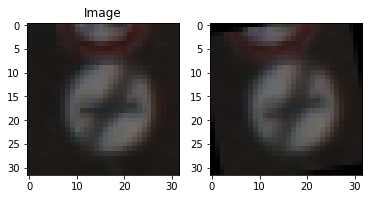

In [43]:
# Rotate images by -10degrees
import matplotlib.pyplot as plt
import cv2
def rotateImage(image, angle):
    image_center = tuple(np.array(image.shape)/2)
    rot_mat = cv2.getRotationMatrix2D((image_center[0], image_center[1]),angle, 1)
    rotated_image = cv2.warpAffine(image, rot_mat, (image.shape[0], image.shape[1]),flags=cv2.INTER_LINEAR)
    return rotated_image

image = X_train[0]
rotated_image = rotateImage(image, 10)


fig, axes = plt.subplots(1, 2)
ax = plt.subplot(1, 2, 1)
ax.set_title("Image")
ax.imshow(image)

# Plot a sample image from the class
ax = plt.subplot(1, 2, 2)
ax.imshow(rotated_image)

plt.show()

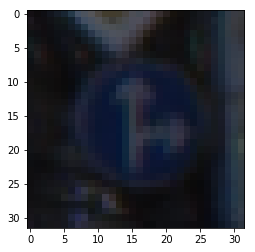

TypeError: translateImage() missing 1 required positional argument: 'tfactor'

In [44]:
import cv2
def translateImage(image, tfactor):
    rows,cols, channel = image.shape
    M = np.float32([[1,0, int(tfactor*rows)],[0,1, int(tfactor*cols)]])
    translated_image = cv2.warpAffine(image, M, (cols,rows))
    return translated_image

image = X_train[1002]
plt.imshow(image)
plt.show()

translated_image = translateImage(image)
plt.imshow(translated_image)
plt.show()

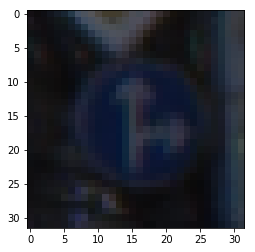

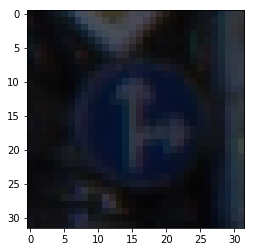

In [45]:
def reduceBrightness(image, pixel_value):
    reduced_brightness_image = image[:,:,:] - pixel_value
    return reduced_brightness_image

img = X_train[1002]
reduced_brightness = reduceBrightness(image, 5)

rows,cols, t = img.shape
plt.imshow(img)
plt.show()

plt.imshow(reduced_brightness)
plt.show()

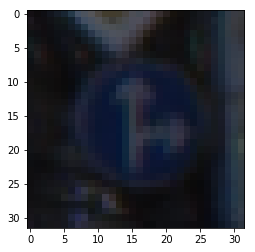

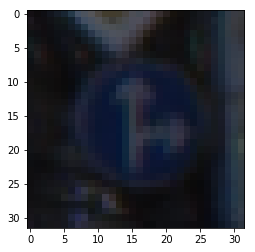

In [46]:
def lossyResize(img):
    resized_image = cv2.resize(img, (16,16))
    dst = cv2.resize(img, (32,32))
    return dst

img = X_train[1002]
rows,cols, t = img.shape
plt.imshow(img)
plt.show()

dst = lossyResize(img)
plt.imshow(dst)
plt.show()
            

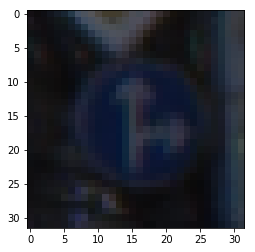

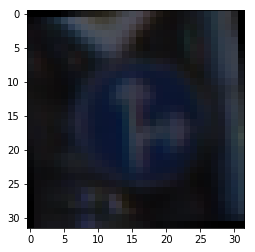

In [47]:
# Define a pipeline of image transformations 
from random import randint

def augment_image(image):
    rotation_angles = [-10, -5, 0, 5, 10]
    translation_factors = [-0.1, 0, 0.1]
    pixel_values = [-5, 0, 5]
    
    rotation_index = randint(0, len(rotation_angles)-1)
    translation_index = randint(0, len(translation_factors)-1)
    pixel_index = randint(0, len(pixel_values)-1)
    
    doRotateImage = randint(0, 1);
    doTranslateImage = randint(0, 1);
    doReduceBrightness = randint(0, 1);
    doLossyResize = randint(0, 1);
    
    if doRotateImage == 1:
        image = rotateImage(image, rotation_angles[rotation_index])
    
    if doTranslateImage == 1:
        image = translateImage(image, translation_factors[translation_index])
    
    if doReduceBrightness == 1:
        image = reduceBrightness(image, pixel_values[pixel_index])
    
    if doLossyResize == 1:
        image = lossyResize(image)
    
    return image
    

img = X_train[1002]
plt.imshow(img)
plt.show()

dst = augment_image(img)
plt.imshow(dst)
plt.show()

Number of images added =  26369


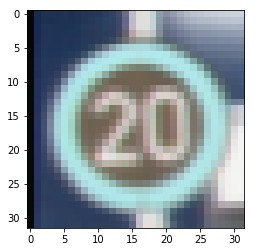

In [68]:
# Compute the number of samples per class required to increase the class representation to mean of 1200 images 
samples_required_per_class = mean_examples - num_samples_per_class
new_X = [];
new_y = [];
for idx in range(number_of_classes):
    if samples_required_per_class[idx] > 0:
        augmentation_factor = int(samples_required_per_class[idx]/num_samples_per_class[idx]) + 1
        find_index_result = np.where(y == idx);
        class_sample_indices = find_index_result[0];
        for idy in range(len(class_sample_indices)):
            image = X[class_sample_indices[idy]]
            for idz in range(augmentation_factor):
                augmented_image = augment_image(image)
                new_X.append(augmented_image)
                new_y.append(idx)

new_X = np.array(new_X)
new_y = np.array(new_y)


print("Number of images added = ", new_X.shape[0])
fig = plt.figure()
plt.imshow(new_X[0])
plt.show()


In [69]:

print("Percent distribution (train, valid, test) = ", percent_train, ",", percent_valid, ",", percent_test )
# Stack up all data - samples and classes from training, test and validation sets
X = np.vstack((X, new_X))
y = np.concatenate((y, new_y))

# Split the data into training and validation dataset
indices = np.arange(X.shape[0])
np.random.shuffle(indices)

training_samples = int(np.ceil(X.shape[0]*percent_train))
validation_samples = int(np.ceil(X.shape[0]*percent_valid))
training_indices, validation_indices, test_indices = indices[:training_samples], indices[training_samples:training_samples+validation_samples], indices[training_samples+validation_samples:]

X_train, y_train = X[training_indices, :,:,:], y[training_indices]
X_valid, y_valid = X[validation_indices, :,:,:], y[validation_indices]
X_test, y_test = X[test_indices, :,:,:], y[test_indices]

new_total_samples = X_train.shape[0] + X_valid.shape[0] + X_test.shape[0]
new_percent_train = X_train.shape[0]/new_total_samples
new_percent_test =  X_test.shape[0]/new_total_samples
new_percent_valid = X_valid.shape[0]/new_total_samples

print("Percent distribution after augmentation(train, valid, test) = ", new_percent_train, ",", new_percent_valid, ",", new_percent_test )

Percent distribution (train, valid, test) =  0.6712899554389552 , 0.08507108547618589 , 0.24363895908485889
Percent distribution after augmentation(train, valid, test) =  0.6712996112929623 , 0.08508081014729951 , 0.24361957855973815


Total sample size = 78208
Percent distribution (train, valid, test) =  0.6712996112929623 , 0.08508081014729951 , 0.24361957855973815


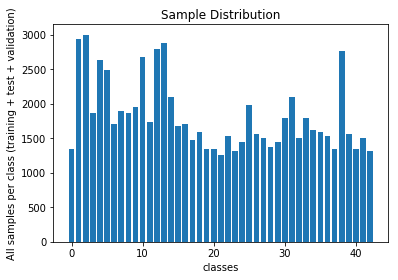

In [70]:
### Data exploration visualization code goes here.
### Number of data points per class. 
import numpy as np
import cv2

total_samples = X_train.shape[0] + X_valid.shape[0] + X_test.shape[0]
print("Total sample size =", total_samples)

percent_train = X_train.shape[0]/total_samples
percent_test  = X_test.shape[0]/total_samples
percent_valid = X_valid.shape[0]/total_samples

print("Percent distribution (train, valid, test) = ", percent_train, ",", percent_valid, ",", percent_test )
# Stack up all data - samples and classes from training, test and validation sets
X = np.vstack((X_train, X_valid, X_test))
y = np.concatenate((y_train, y_valid, y_test))

# Get number of unique class labels
unique_values, unique_indices = np.unique(y_train, return_index=True)
number_of_classes = len(unique_values)

# Get a distribution of number of samples per class
num_samples_per_class = np.zeros(number_of_classes)

# Compute the average of all samples per class
average_image_per_class = np.zeros((number_of_classes, 32, 32, 3))
for idx in range(y.shape[0]):
    num_samples_per_class[y[idx]] += 1
    average_image_per_class[y[idx]] += X[idx]

# Plot per class sample distribution
plt.close('all')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(range(number_of_classes), num_samples_per_class)
ax.set_xlabel("classes")
ax.set_ylabel("All samples per class (training + test + validation)")
ax.set_title("Sample Distribution")
plt.show()

In [71]:
# Generate statistics on min vs max represented class

# Get class labels with minimum and maximum samples 
# and mean number of samples across all classes
min_examples = np.min(num_samples_per_class)
max_examples = np.max(num_samples_per_class)
mean_examples = np.mean(num_samples_per_class)

print("minimum examples per class =", min_examples)
print("maximum examples per class =", max_examples)
print("mean number of examples across all classes=", mean_examples)

# Find the class names that map to the min/max sample class ids 
min_represented_classes = np.where(num_samples_per_class == min_examples)
min_classes = min_represented_classes[0]

max_represented_classes = np.where(num_samples_per_class == max_examples)
max_classes = max_represented_classes[0]


min_signals = [signal_names[idx] for idx in min_classes]
print("Class with min samples =", min_signals)

max_signals = [signal_names[idx] for idx in max_classes]
print("Class with max samples =", max_signals)

minimum examples per class = 1260.0
maximum examples per class = 3000.0
mean number of examples across all classes= 1818.79069767
Class with min samples = ['Double curve']
Class with max samples = ['Speed limit (50km/h)']


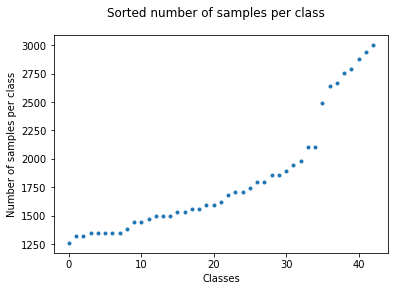

In [72]:
# Plot trend of number of samples per class
fig = plt.figure()
plt.plot(range(number_of_classes), sorted(num_samples_per_class), '.')
fig.suptitle('Sorted number of samples per class')
plt.xlabel('Classes')
plt.ylabel('Number of samples per class')
plt.show()


# Explore grayscale and histogram equalization of images 

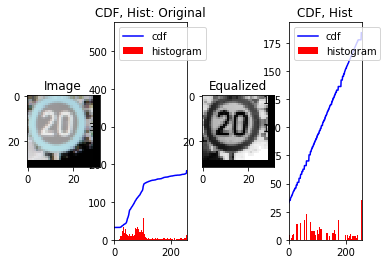

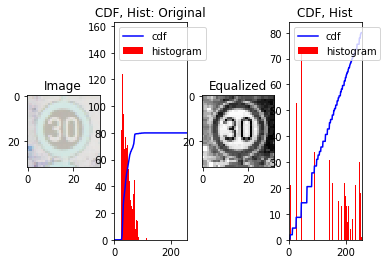

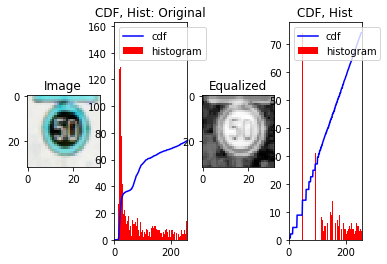

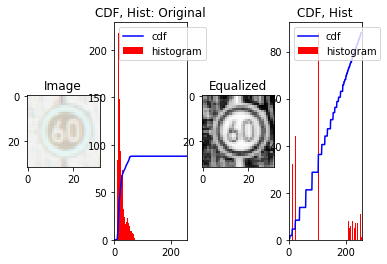

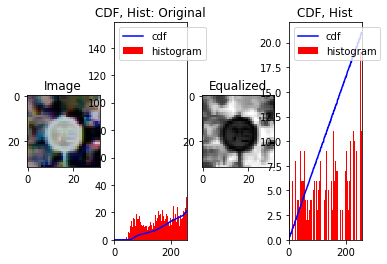

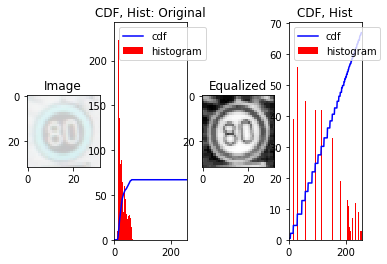

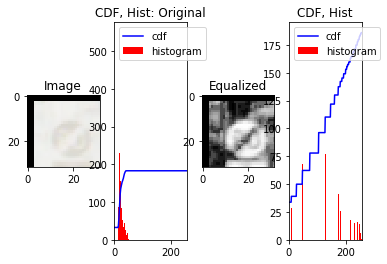

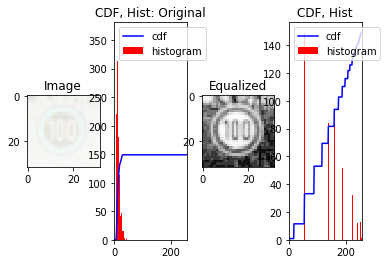

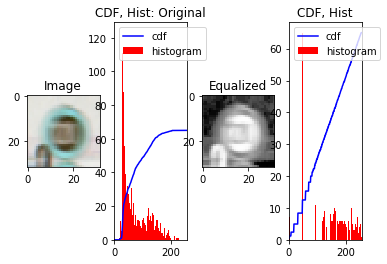

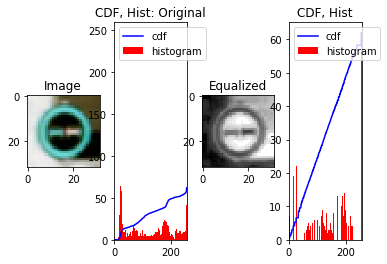

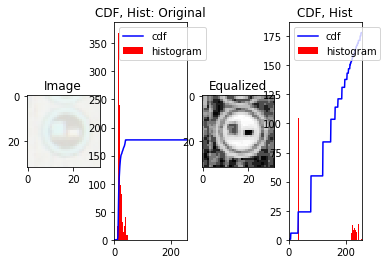

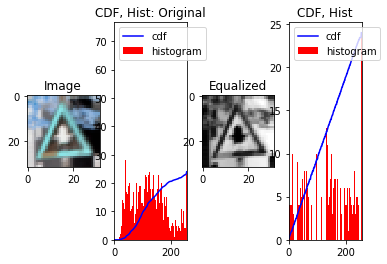

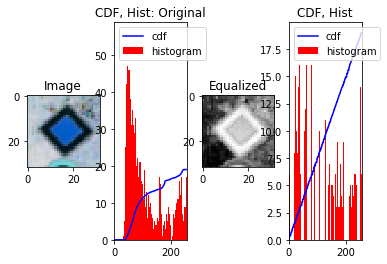

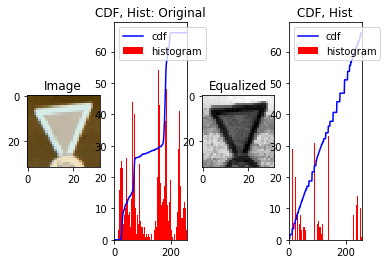

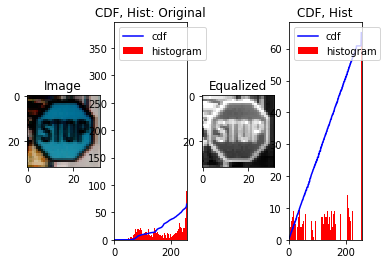

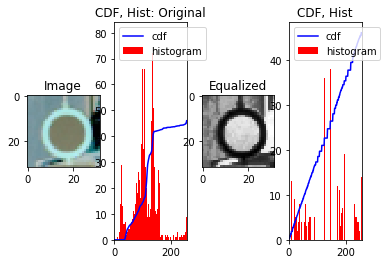

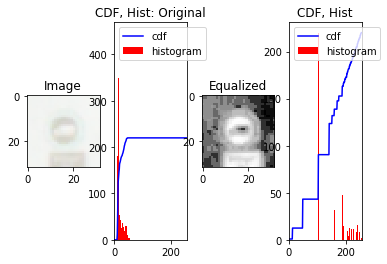

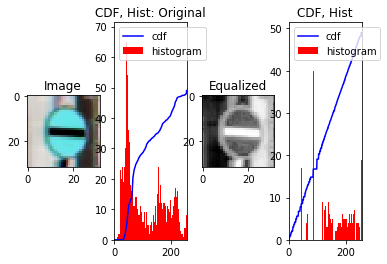

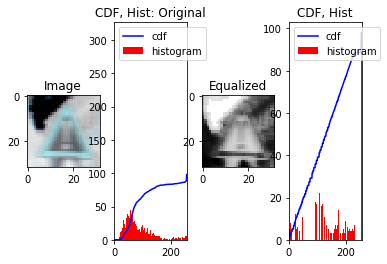

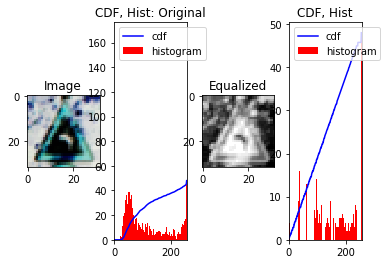

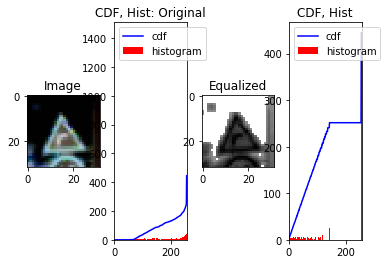

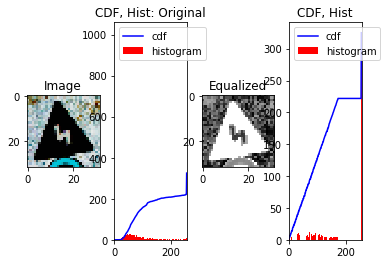

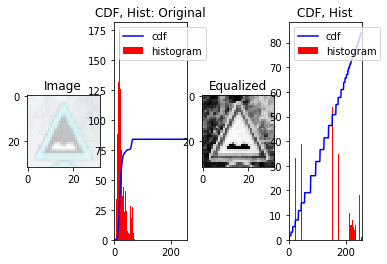

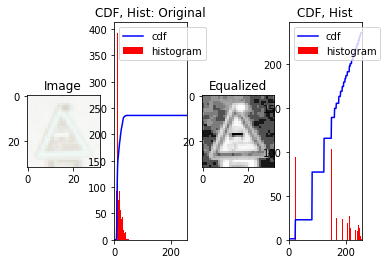

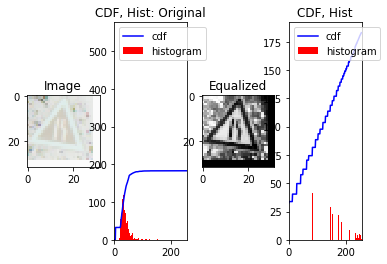

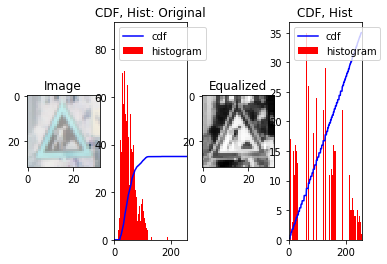

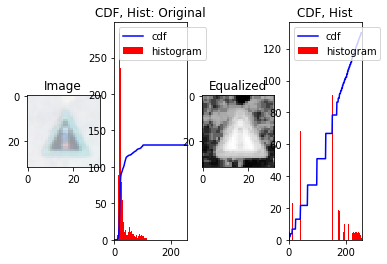

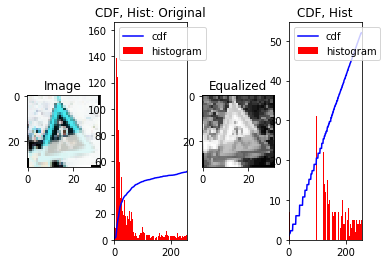

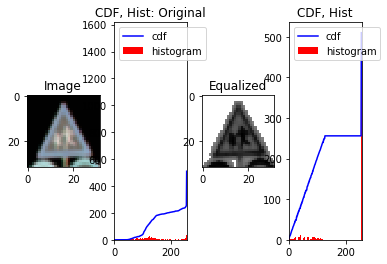

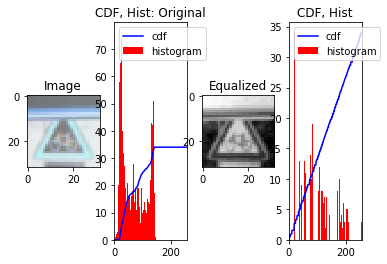

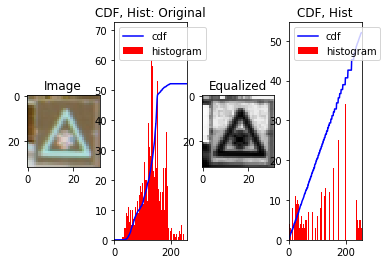

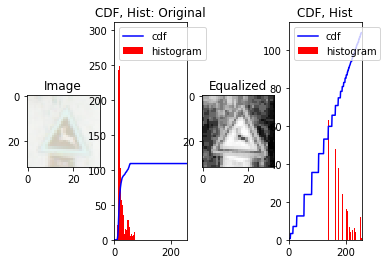

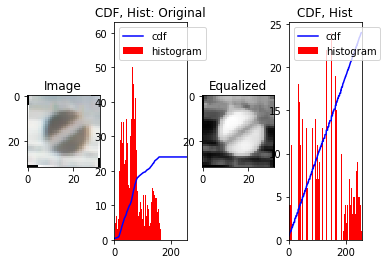

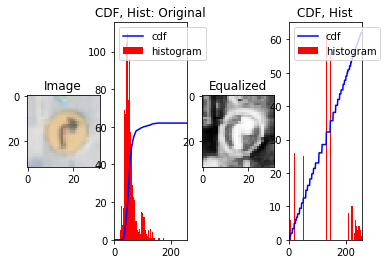

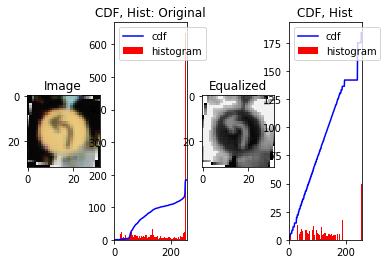

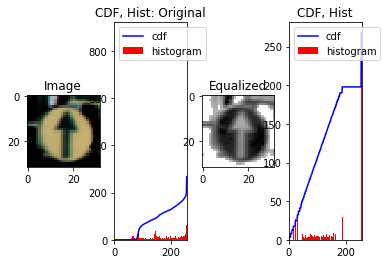

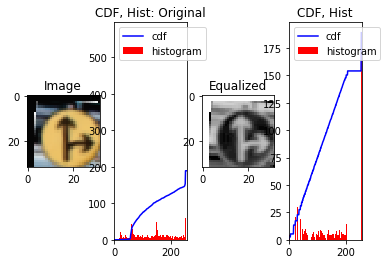

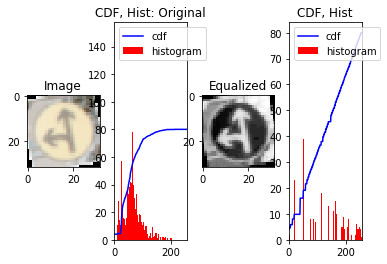

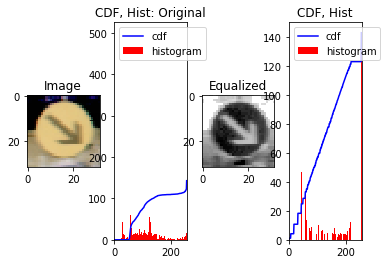

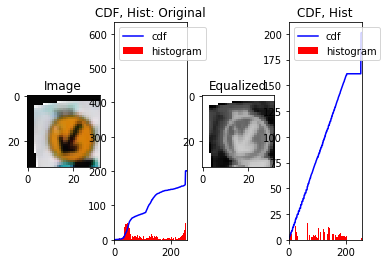

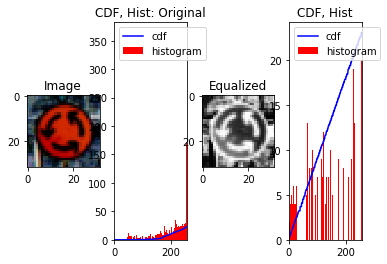

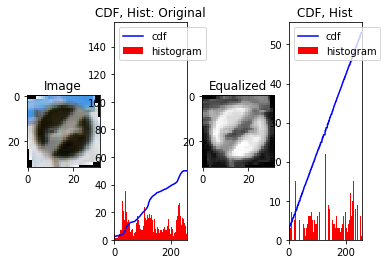

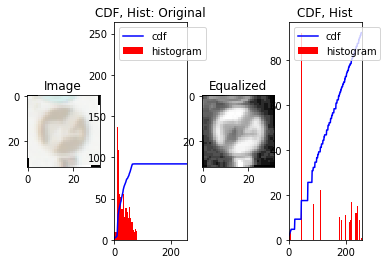

In [77]:
### Histogram Equalization
import matplotlib.pyplot as plt
import numpy as np
import cv2
from numpy import newaxis
# Sharpen images using histogram equalization

def computeCDF(image):
    # Compute cumlative distribution function using histogram binning of values 
    hist, bins = np.histogram(image.flatten(), 256, [0, 256])
    cdf = hist.cumsum()
    
    #Normalize cdf 
    cdf_normalized = cdf * hist.max()/cdf.max()
    return cdf_normalized

def equalizeImage(image, cdf):
    # Equalize image by normalizing the values and applying a mask 
    cdf_m = np.ma.masked_equal(cdf,0)
    cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
    cdf_equ = np.ma.filled(cdf_m, 0).astype('uint8')
    image_equ = cdf_equ[image]
    return image_equ

def process_image(image):
    # Compute histogram equalization on the grayscale of an image 
    # Compute cdf on the equalized image
    image = np.array(image, dtype=np.uint8)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    cdf = computeCDF(image)
    equalized_image = equalizeImage(image, cdf)
    cdf_equ = computeCDF(equalized_image)
    return image, cdf, equalized_image, cdf_equ
    
def process_image_for_nn(image):
    # Helper API to sharpen an image using histogram equalization
    # To be used in preprocessing step
    image = np.array(image, dtype=np.uint8)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    cdf = computeCDF(image)
    equalized_image = equalizeImage(image, cdf)
    return equalized_image[:,:,newaxis]

# Visualizations will be shown in the notebook.
%matplotlib inline
unique_values, unique_indices = np.unique(y_train, return_index=True)

# For each class, get a sample image from the class and visually present the 
# result of histogram equalization
for idx in range(len(unique_values)):
    image = X_train[unique_indices[idx]]
    other_image, cdf, equalized_image, cdf_equ = process_image(image)
    fig, axes = plt.subplots(1, 4)
    ax = plt.subplot(1, 4, 1)
    ax.set_title("Image")
    plt.imshow(image)

    ax = plt.subplot(1, 4, 2)
    ax.set_title("CDF, Hist: Original")
    plt.plot(cdf, color="b")
    plt.hist(image.flatten(), 256, [0, 256], color = "r")
    plt.xlim([0, 256])
    plt.legend(('cdf', 'histogram'), loc="upper left")
    
    
    ax = plt.subplot(1, 4, 3)
    ax.set_title("Equalized")
    plt.imshow(equalized_image, cmap='gray')
    
    ax = plt.subplot(1, 4, 4)
    ax.set_title("CDF, Hist")
    plt.plot(cdf_equ, color="b")
    plt.hist(equalized_image.flatten(), 256, [0, 256], color = "r")
    plt.xlim([0, 256])
    plt.legend(('cdf', 'histogram'), loc="upper left")
    
    plt.show()


# Reshuffle data to create a uniform distribution of training set 
In order to get a good (similar) distribution of classes in training and validation sets, combine the training and validation sets and reshuffle the data.



Reshuffled data distribution


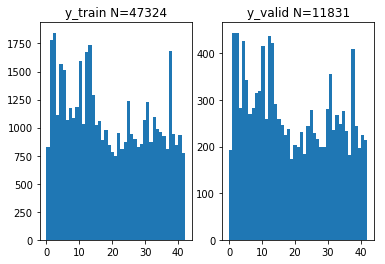

In [78]:
# Shuffle data to ensure there is a 80-20 split of training & validation datasets

# Combine training and validation datasets 
X = np.vstack((X_train, X_valid))
y = np.concatenate((y_train, y_valid))

# Process all images to gray scale and sharpen the image
# via histogram equalization
X_gray = np.zeros((X.shape[0], 32, 32, 1))
for idx in range(X.shape[0]):
    X_gray[idx] = process_image_for_nn(X[idx])

# Split the data into training and validation dataset
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
training_samples = int(np.ceil(X.shape[0]*0.8))
training_indices, validation_indices = indices[:training_samples], indices[training_samples:]

X_train, y_train = X_gray[training_indices, :,:,:], y[training_indices]
X_valid, y_valid = X_gray[validation_indices, :,:,:], y[validation_indices]

# Print the data distribution
print("Reshuffled data distribution")
fig, axes = plt.subplots(1, 2)
ax = plt.subplot(1,2,1)
ax.set_title("y_train N=" + str(len(y_train)))
plt.hist(y_train, bins=43)

ax = plt.subplot(1,2,2)
ax.set_title("y_valid N=" + str(len(y_valid)))
plt.hist(y_valid, bins=43)
plt.show()

data["train"] = (X_train, y_train)

data["valid"] = (X_valid, y_valid)

In [79]:
# Process all test images to apply the same preprocessing steps as the training
# and validation sets 
X_gray_test = np.zeros((X_test.shape[0], 32,32,1))
for idx in range(X_test.shape[0]):
    X_gray_test[idx] = process_image_for_nn(X_test[idx])


### Model Architecture

In [82]:
# Define model architecture for CNN to identify traffic signals 
import tensorflow as tf
from tensorflow.contrib.layers import flatten

### Define your architecture here.
### Feel free to use as many code cells as needed.
def getLeNet(x, dropout):
    mu = 0
    sigma = 0.1

    # Define a Convolutional Layer with filter sizes of 5x5 and 6 output nodes 
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5,5,1,6), mean=mu, stddev=sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x, conv1_W, strides=[1,1,1,1], padding="VALID") +  conv1_b
    
    # Apply relu activation function
    conv1 = tf.nn.relu(conv1)
    
    # Apply a maxpooling layer with filter sizes of 2x2
    conv1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding="VALID")

    # Define the second Convolution Layer with filter sizes of 5x5 and 16 output nodes
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5,5,6,16), mean=mu, stddev=sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1,1,1,1], padding="VALID") + conv2_b
    
    # Apply relu activation function 
    conv2 = tf.nn.relu(conv2)
    
    # Apply a max pooling layer with filter sizes of 2x2
    conv2 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding="VALID")

    # Flatten the output of convolutional layer to get 400 output nodes
    fc0   = flatten(conv2)

    # Use fully connected layers with 120 output nodes
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean=mu, stddev=sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Use relu activation function 
    fc1 = tf.nn.relu(fc1)

    # Use fully connected layers with 84 output nodes 
    fc2_W = tf.Variable(tf.truncated_normal(shape=(120, 84), mean=mu, stddev=sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2 = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Use relu activation function 
    fc2 = tf.nn.relu(fc2)
    
    # Apply a dropout layer before giving inputs to the final layer 
    fc2 = tf.nn.dropout(fc2, dropout)

    # Use fully connected layer with 43 output nodes mapping to the number of class labels 
    fc3_W = tf.Variable(tf.truncated_normal(shape=(84, 43), mean=mu, stddev=sigma))
    fc3_b = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    # return logits as output layer 
    return logits


# Define learning_rate, dropout, epochs and batch sizes
learning_rate=0.001
dropout = 0.9
epochs = 20
batch_size=128

# Define input placeholders 
x = tf.placeholder(tf.float32, (None, 32,32,1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder(tf.float32, (None))

# get logits from leNet
leNet = getLeNet(x, keep_prob)

# get the cross_entropy using training y labels
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=leNet, labels=one_hot_y)

# Define loss_operation and use it in AdamOptimizer
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_operation = optimizer.minimize(loss_operation)

# Define accuracy score using optimizer and expected y labels 
correct_prediction = tf.equal(tf.argmax(leNet, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [84]:
# Define evaluation function which takes in X and Y along with a dropout value 
# Split data into batches to run it through the accuracy operation to estimate 
# the overall performance of the model on the validation and test sets
def evaluate(X_data, y_data, dropout):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        end = offset + batch_size
        batchx, batchy = X_data[offset:end], y_data[offset:end]
        accuracy = sess.run(accuracy_operation, feed_dict={x:batchx, y:batchy, keep_prob:dropout})
        total_accuracy += (accuracy*len(batchx))
    return total_accuracy/num_examples

### Train your model here.
### Calculate and report the accuracy on the training and validation set.
saver = tf.train.Saver()
with tf.Session() as sess:
    file_writer = tf.summary.FileWriter('.', sess.graph)
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)

    # Fore each epoch, reshuffle indices and train the model in batches of 128
    for i in range(epochs):
        indices = np.arange(X_train.shape[0])
        np.random.shuffle(indices)
        X_train, y_train = X_train[indices, :,:,:], y_train[indices]
            
        for offset in range(0, num_examples, batch_size):
            end = offset + batch_size
            batchx, batchy = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x:batchx, y:batchy, keep_prob:dropout})
        
        training_accuracy = evaluate(X_train, y_train, dropout)
        validation_accuracy = evaluate(X_valid, y_valid, dropout)
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = " , training_accuracy)
        print("Validation Accuracy = " , validation_accuracy)
        print()


    saver.save(sess, './lenet')
    print("Model Saved")

    ### Once a final model architecture is selected, 
    ### the accuracy on the test set should be calculated and reported as well.
    # Calculate Test Accuracy
    test_accuracy = evaluate(X_gray_test, y_test, dropout)
    print('Testing Accuracy: {}'.format(test_accuracy))

EPOCH 1 ...
Training Accuracy =  0.685043529755
Validation Accuracy =  0.670357535319

EPOCH 2 ...
Training Accuracy =  0.834249006806
Validation Accuracy =  0.818020454989

EPOCH 3 ...
Training Accuracy =  0.882617699209
Validation Accuracy =  0.855548981661

EPOCH 4 ...
Training Accuracy =  0.915497421946
Validation Accuracy =  0.885892993156

EPOCH 5 ...
Training Accuracy =  0.929211393715
Validation Accuracy =  0.899754881093

EPOCH 6 ...
Training Accuracy =  0.944890541701
Validation Accuracy =  0.909897725919

EPOCH 7 ...
Training Accuracy =  0.956406897054
Validation Accuracy =  0.918941762933

EPOCH 8 ...
Training Accuracy =  0.949158989011
Validation Accuracy =  0.9091370127

EPOCH 9 ...
Training Accuracy =  0.965366410187
Validation Accuracy =  0.926379849477

EPOCH 10 ...
Training Accuracy =  0.968113430717
Validation Accuracy =  0.931451272047

EPOCH 11 ...
Training Accuracy =  0.970163130763
Validation Accuracy =  0.93145127185

EPOCH 12 ...
Training Accuracy =  0.96999408

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

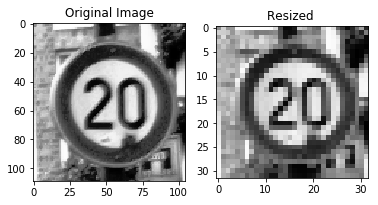

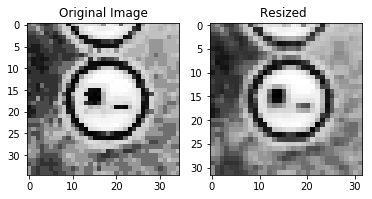

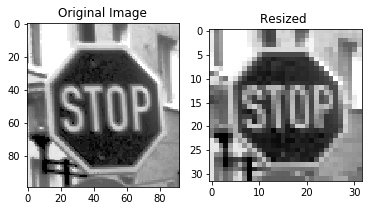

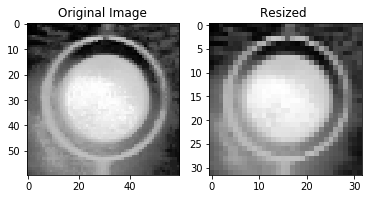

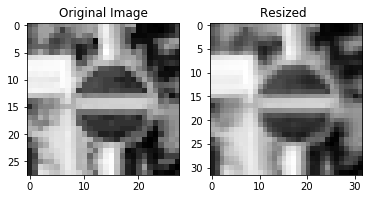

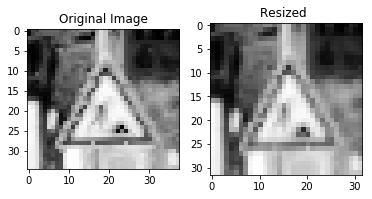

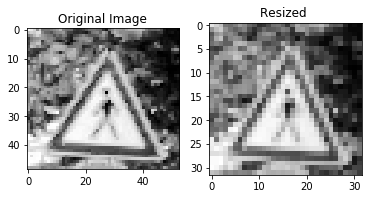

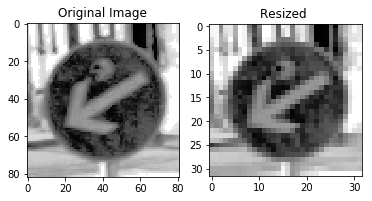

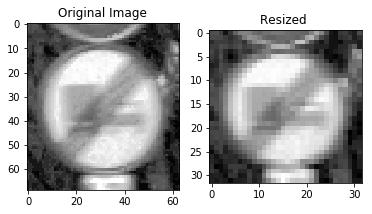

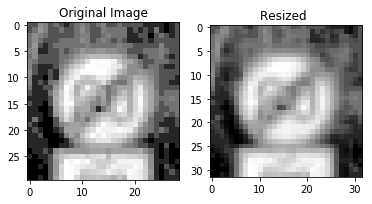

In [79]:
### Load the images and plot them here.
import os, sys
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import csv
import cv2

# Load metaData.csv file which contains the information about the test images
def collect_meta_data(meta_data_file):
    data = {};
    field_names=[]
    data_struct = {};
    
    with open(meta_data_file, 'r') as csvfile:
        is_first_row=1
        spamreader = csv.reader(csvfile, delimiter=';')
        for row in spamreader:
            if len(row) == 0:
                continue;
            # For the first row, get all the field names and store it in data 
            if is_first_row==1:
                for idx in range(len(row)):
                    data[row[idx]] = ""
                    field_names.append(row[idx]);
                is_first_row=0
            else:
                # for all other rows, make a copy of data
                # Append row values as field values in data dict 
                new_data = data.copy()
                for idx in range(len(row)):
                    new_data[field_names[idx]] = row[idx];
                data_struct[row[0]] = new_data;
    return data_struct

# Given a source folder name and file name, load image and 
# apply pre-processing algorithm to make it ready for CNN 
def load_image(source_folder, file_name):
    s="";
    parts = file_name.split("_")
    classid_info = parts[0].split("Class")
    classid = int(classid_info[1])

    sequence=(source_folder, file_name)
    file_path = s.join(sequence)
    image = cv2.imread(file_path)
    gray_image = process_image_for_nn(image)
    return gray_image, classid

# Meta data file name for the new test images from the German traffic dataset 
meta_data_file = "./test_images/metaData.csv"

# Collect metadata
meta_data= collect_meta_data(meta_data_file)

# For each image in the test images folder 
src_folder = "./test_images/"
file_list = os.listdir(src_folder)

new_X_test = []
new_y_test = []
for file in file_list:
    if str.endswith(file, ".png"):
        # Load image 
        image, classid = load_image(src_folder, file)
        
        file_parts = file.split('.')
        image_name = file_parts[0]
        
        # Load annotation 
        annotation = meta_data[image_name]
        x1, x2, y1, y2 = int(annotation['Roi.X1']), int(annotation['Roi.X2']), int(annotation['Roi.Y1']), int(annotation['Roi.Y2'])
        
        # The model is trained on uncropped images and hence the below algorithm is not required
        #print((x1,x2,y1,y2))
        #cropped_image = image[y1:y2, x1:x2]
        
        # Use the entire image for testing 
        cropped_image = image
        
        # Plot the results of pre processing on the test images 
        fig = plt.figure()
        fig, axes = plt.subplots(1, 2)
        ax = plt.subplot(1, 2, 1)
        ax.set_title("Original Image")
        plt.imshow(cropped_image[:,:,0], cmap="gray")
        
        resized_image = cv2.resize(cropped_image, (32,32))
        resized_image = resized_image[:,:, newaxis]
        
        ax = plt.subplot(1, 2, 2)
        ax.set_title("Resized ")
        plt.imshow(resized_image[:,:,0], cmap="gray")

        new_X_test.append(resized_image)
        new_y_test.append(classid)

new_X_test = np.array(new_X_test)
new_y_test = np.array(new_y_test)


### Predict the Sign Type for Each Image and Analyze Performance 

In [80]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
import tensorflow as tf
model_checkpoint = './lenet'
# Define evaluation function which takes in X and Y along with a dropout value 
# Split data into batches to run it through the accuracy operation to estimate 
# the overall performance of the model on the validation and test sets
def evaluate(X_data, y_data, dropout):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        end = offset + batch_size
        batchx, batchy = X_data[offset:end], y_data[offset:end]
        preds  = sess.run(correct_prediction, feed_dict={x:batchx, y:batchy, keep_prob:dropout})
        print(preds)
        
        accuracy = sess.run(accuracy_operation, feed_dict={x:batchx, y:batchy, keep_prob:dropout})
        total_accuracy += (accuracy*len(batchx))
    return total_accuracy/num_examples

with tf.Session() as sess:
    # Restore the model
    tf_saver = tf.train.Saver()
    tf_saver.restore(sess, model_checkpoint)
    
    # Standard - Calculate Test Accuracy
    test_accuracy = evaluate(new_X_test, new_y_test, dropout)
    print('Testing Accuracy: {}'.format(test_accuracy))
    
    # Calculate top six classes 
    softmax_probs = tf.nn.softmax(leNet)
    top_predictions = tf.nn.top_k(softmax_probs, k=6)
    top_k_probabilities = sess.run(top_predictions, feed_dict={x:new_X_test, y:new_y_test, keep_prob:dropout})
    print(top_k_probabilities)
    
    # Compute accuracy based on top_k_predictions
    in_top_predictions = tf.nn.in_top_k(softmax_probs, y, k=6)
    score = sess.run(in_top_predictions, feed_dict={x:new_X_test, y:new_y_test, keep_prob:dropout})
    print(score)

INFO:tensorflow:Restoring parameters from ./lenet


NotFoundError: Key beta2_power_9 not found in checkpoint
	 [[Node: save_40/RestoreV2_329 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_arg_save_40/Const_0_0, save_40/RestoreV2_329/tensor_names, save_40/RestoreV2_329/shape_and_slices)]]
	 [[Node: save_40/RestoreV2_235/_241 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_904_save_40/RestoreV2_235", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op 'save_40/RestoreV2_329', defined at:
  File "C:\Users\Vaidehi\AppData\Local\conda\conda\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Vaidehi\AppData\Local\conda\conda\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Vaidehi\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Vaidehi\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\Vaidehi\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\Vaidehi\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\Vaidehi\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\Vaidehi\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Vaidehi\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\Vaidehi\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\Vaidehi\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\Vaidehi\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Vaidehi\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\Vaidehi\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\Vaidehi\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\Vaidehi\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\Vaidehi\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\Vaidehi\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\Vaidehi\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\Vaidehi\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-80-63b15373df3d>", line 24, in <module>
    tf_saver = tf.train.Saver()
  File "C:\Users\Vaidehi\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\tensorflow\python\training\saver.py", line 1139, in __init__
    self.build()
  File "C:\Users\Vaidehi\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\tensorflow\python\training\saver.py", line 1170, in build
    restore_sequentially=self._restore_sequentially)
  File "C:\Users\Vaidehi\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\tensorflow\python\training\saver.py", line 691, in build
    restore_sequentially, reshape)
  File "C:\Users\Vaidehi\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\tensorflow\python\training\saver.py", line 407, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "C:\Users\Vaidehi\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\tensorflow\python\training\saver.py", line 247, in restore_op
    [spec.tensor.dtype])[0])
  File "C:\Users\Vaidehi\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\tensorflow\python\ops\gen_io_ops.py", line 640, in restore_v2
    dtypes=dtypes, name=name)
  File "C:\Users\Vaidehi\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "C:\Users\Vaidehi\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Users\Vaidehi\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

NotFoundError (see above for traceback): Key beta2_power_9 not found in checkpoint
	 [[Node: save_40/RestoreV2_329 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_arg_save_40/Const_0_0, save_40/RestoreV2_329/tensor_names, save_40/RestoreV2_329/shape_and_slices)]]
	 [[Node: save_40/RestoreV2_235/_241 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_904_save_40/RestoreV2_235", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [75]:
### Visualize your network's feature maps here.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry
import tensorflow as tf

def outputFeatureMap(image_input, label, dropout, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input, y: label, keep_prob: dropout})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

            
def evaluate(X_data, y_data, dropout):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        end = offset + batch_size
        batchx, batchy = X_data[offset:end], y_data[offset:end]
        
        accuracy = sess.run(accuracy_operation, feed_dict={x:batchx, y:batchy, keep_prob:dropout})
        total_accuracy += (accuracy*len(batchx))
    return total_accuracy/num_examples


# Define learning_rate, dropout, epochs and batch sizes
learning_rate=0.001
dropout = 0.9
epochs = 10
batch_size=128

# Define input placeholders 
x = tf.placeholder(tf.float32, (None, 32,32,1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder(tf.float32, (None))

mu = 0
sigma = 0.1

conv1_W = tf.Variable(tf.truncated_normal(shape=(5,5,1,6), mean=mu, stddev=sigma))
conv1_b = tf.Variable(tf.zeros(6))
conv1_c = tf.nn.conv2d(x, conv1_W, strides=[1,1,1,1], padding="VALID") +  conv1_b
conv1 = tf.nn.relu(conv1_c)
conv1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding="VALID")

conv2_W = tf.Variable(tf.truncated_normal(shape=(5,5,6,16), mean=mu, stddev=sigma))
conv2_b = tf.Variable(tf.zeros(16))
conv2_c = tf.nn.conv2d(conv1, conv2_W, strides=[1,1,1,1], padding="VALID") + conv2_b
conv2 = tf.nn.relu(conv2_c)
conv2 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding="VALID")

fc0   = flatten(conv2)

fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean=mu, stddev=sigma))
fc1_b = tf.Variable(tf.zeros(120))
fc1 = tf.matmul(fc0, fc1_W) + fc1_b
fc1 = tf.nn.relu(fc1)

fc2_W = tf.Variable(tf.truncated_normal(shape=(120, 84), mean=mu, stddev=sigma))
fc2_b = tf.Variable(tf.zeros(84))
fc2 = tf.matmul(fc1, fc2_W) + fc2_b
fc2 = tf.nn.relu(fc2)
fc2 = tf.nn.dropout(fc2, dropout)

fc3_W = tf.Variable(tf.truncated_normal(shape=(84, 43), mean=mu, stddev=sigma))
fc3_b = tf.Variable(tf.zeros(43))
logits = tf.matmul(fc2, fc3_W) + fc3_b


# get logits from leNet
leNet = logits

# get the cross_entropy using training y labels
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=leNet, labels=one_hot_y)

# Define loss_operation and use it in AdamOptimizer
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_operation = optimizer.minimize(loss_operation)

# Define accuracy score using optimizer and expected y labels 
correct_prediction = tf.equal(tf.argmax(leNet, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


### Train your model here.
### Calculate and report the accuracy on the training and validation set.
saver = tf.train.Saver()
with tf.Session() as sess:
    file_writer = tf.summary.FileWriter('.', sess.graph)
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)

    for i in range(epochs):
        indices = np.arange(X_train.shape[0])
        np.random.shuffle(indices)
        X_train, y_train = X_train[indices, :,:,:], y_train[indices]
            
        for offset in range(0, num_examples, batch_size):
            end = offset + batch_size
            batchx, batchy = X_train[offset:end], y_train[offset:end]
            if batchx.shape[0] > 1:
                sess.run(training_operation, feed_dict={x:batchx, y:batchy, keep_prob:dropout})

        validation_accuracy = evaluate(X_valid, y_valid, dropout)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = " , validation_accuracy)
        print()

    saver.save(sess, './lenet_without_helper_functions')
    print("Model Saved")

EPOCH 1 ...
Validation Accuracy =  0.644943247232

EPOCH 2 ...
Validation Accuracy =  0.789695192168

EPOCH 3 ...
Validation Accuracy =  0.852697360015

EPOCH 4 ...
Validation Accuracy =  0.882668027022

EPOCH 5 ...
Validation Accuracy =  0.904221400575

EPOCH 6 ...
Validation Accuracy =  0.91748501491

EPOCH 7 ...
Validation Accuracy =  0.924754495843

EPOCH 8 ...
Validation Accuracy =  0.927815329662

EPOCH 9 ...
Validation Accuracy =  0.934574671712

EPOCH 10 ...
Validation Accuracy =  0.936487693124

Model Saved


INFO:tensorflow:Restoring parameters from ./lenet_without_helper_functions


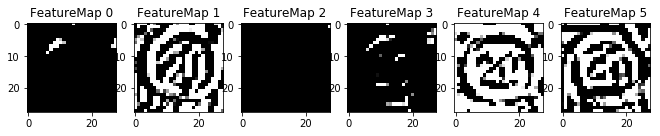

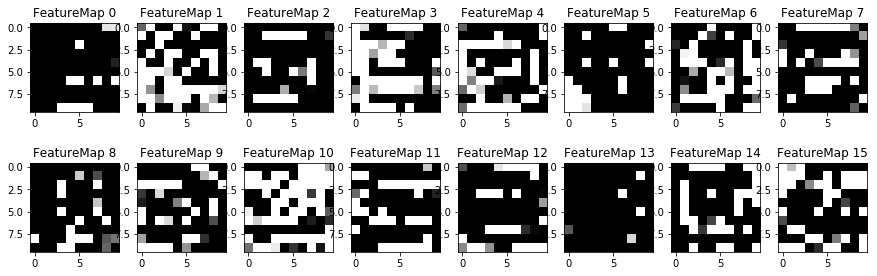

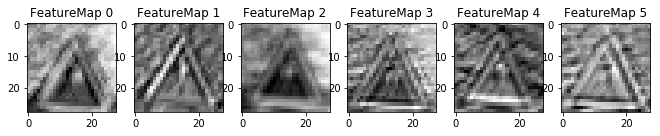

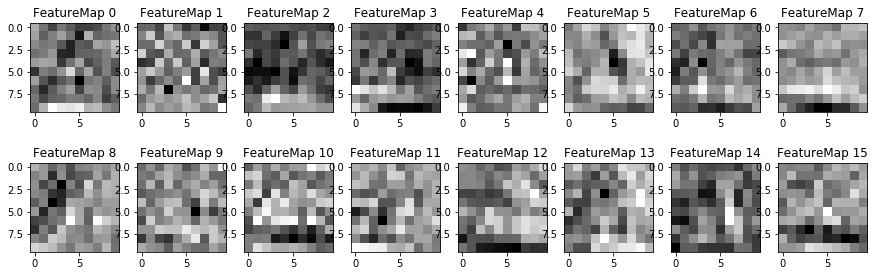

In [78]:
import tensorflow as tf
model_checkpoint = './lenet_without_helper_functions'

with tf.Session() as sess:
    # Restore the model
    tf_saver = tf.train.Saver()
    tf_saver.restore(sess, model_checkpoint)
    
    image_input = [new_X_test[0]]
    label = [new_y_test[0]]
    
    
    outputFeatureMap(image_input, label, dropout, conv1_c, activation_min=-2, activation_max=2, plt_num=1)
    
    outputFeatureMap(image_input, label, dropout, conv2_c, activation_min=-2, activation_max=2, plt_num=2)
    
    
    image_input = [new_X_test[4]]
    label = [new_y_test[4]]

    outputFeatureMap(image_input, label, dropout, conv1_c, plt_num=3)
    
    outputFeatureMap(image_input, label, dropout, conv2_c, plt_num=4)
